In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
#sites = ['ADHD1',
#        'ADHD3',
#        'ADHD5',
#        'ADHD6',
#        'HSJ',
#        'Svip1',
#        'Svip2',
#        'SZ3',
#        'SZ6',
#        'UCLA_CB',
#        'UCLA_DS1',
#        'UKBB11025',
#        'UKBB11026',
#        'UKBB11027']

# Order by n in site
sites = ['SZ3',
        'SZ6',
        'Svip2',
        'ADHD6',
        'HSJ',
        'UCLA_CB',
        'Svip1',
        'ADHD1',
        'ADHD3',
        'ADHD5',
        'UCLA_DS1',
        'UKBB11026',
        'UKBB11027',
        'UKBB11025']

p_sex = './results/sex/'

# Load Data

In [30]:
# Single Task
st_data = []
for site in sites:
    folds = []
    for fold in range(5):
        p_parent = os.path.join(p_sex, f"{site}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[site])
    st_data.append(folds)

st_data = dict(zip(sites,st_data))

In [31]:
# Multi-task
mtl_data = []
for fold in range(5):
    p_parent = os.path.join(p_sex, f"all/fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Accuracy

In [32]:
# Single Task
st_acc = []
st_acc_var = []
for site in sites:
    # Connectomes
    vals = [st_data[site][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc.append(np.mean(vals))
    st_acc_var.append(np.var(vals))

st_acc = pd.Series(st_acc,index=sites)
st_acc_var = pd.Series(st_acc_var,index=sites)

In [33]:
# Multi-task
mtl_acc = []
for fold in range(5):
    df = mtl_data[fold].transpose().reset_index()
    df = df[df['level_1']=='Accuracy/test'].set_index('level_0')[99]
    mtl_acc.append(df)
    
mtl_acc_var = pd.concat(mtl_acc,axis=1).var(axis=1)
mtl_acc = pd.concat(mtl_acc,axis=1).mean(axis=1)

# Tables

In [34]:
df = pd.concat([st_acc,mtl_acc,st_acc_var,mtl_acc_var],axis=1)
df.columns = ['ST','MTL','ST_var','MTL_var']
df['diff'] = df['MTL'] - df['ST']
df

,ST,MTL,ST_var,MTL_var,diff
SZ3,57.142857,77.142857,244.897959,265.306122,20.000000
SZ6,71.428571,60.000000,408.163265,346.938776,-11.428571
Svip2,55.000000,65.000000,287.500000,343.750000,10.000000
ADHD6,40.000000,52.500000,525.000000,109.375000,12.500000
HSJ,40.000000,60.000000,400.000000,578.125000,20.000000
UCLA_CB,48.888889,46.666667,128.395062,580.246914,-2.222222
Svip1,54.000000,76.000000,184.000000,430.000000,22.000000
ADHD1,67.272727,74.545455,119.008264,429.752066,7.272727
ADHD3,58.333333,48.333333,222.222222,48.611111,-10.000000
ADHD5,58.750000,55.000000,40.625000,66.406250,-3.750000


In [35]:
df.mean()

ST          62.800042
MTL         67.661195
ST_var     185.326603
MTL_var    234.973463
diff         4.861153
dtype: float64

# Plots

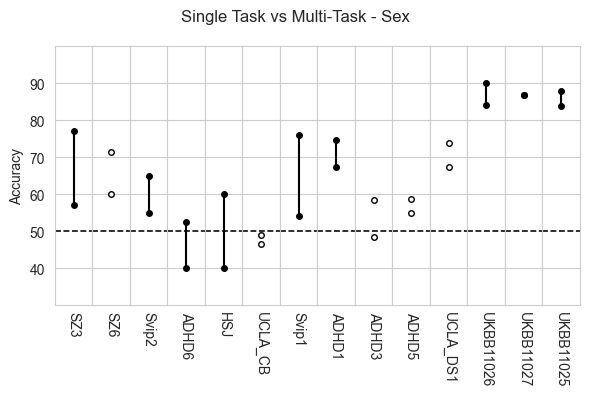

In [25]:
###############
# CONNECTOMES #
###############
title = 'Single Task vs Multi-Task - Sex'
fig,ax = plt.subplots(1,len(sites),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,site in enumerate(sites):
    st_acc = df.loc[site]['ST']
    mtl_acc = df.loc[site]['MTL']
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(sites[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(30,100)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join(p_sex,'figures/st_vs_mtl.png'),dpi=300)